## Utilitity functions for features extraction

C:\Users\Leon\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


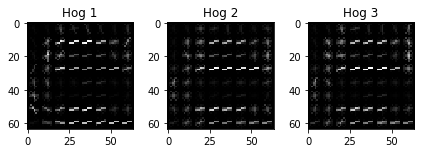

In [1]:
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Extract features utilities
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    ch1_hist = np.histogram(img[:,:,0], bins=nbins)
    ch2_hist = np.histogram(img[:,:,1], bins=nbins)
    ch3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Extract features from a single image
def extract_sig_features(img, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion
    feature_image = convert_color(img)
    #3) Compute spatial features if flag is set
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    #4) Append features to list
    img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    hist_features = color_hist(feature_image, nbins=hist_bins)
    #6) Append features to list
    img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    hog1 = get_hog_features(feature_image[:,:,0], 
                            orient, pix_per_cell, cell_per_block)
    hog2 = get_hog_features(feature_image[:,:,1], 
                            orient, pix_per_cell, cell_per_block)
    hog3 = get_hog_features(feature_image[:,:,2], 
                            orient, pix_per_cell, cell_per_block)

    #8) Append features to list
    img_features.append(hog1)
    img_features.append(hog2)
    img_features.append(hog3)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def extract_features(cars, notcars):
    fcars = []
    for f in cars:
        img = cv2.imread(f).astype(np.float32)/255 # Convert to (0, 1)
        fcars.append(extract_sig_features(img))
    fncars = []
    for f in notcars:
        img = cv2.imread(f).astype(np.float32)/255 # Convert to (0, 1)
        fncars.append(extract_sig_features(img))
    return np.vstack((fcars, fncars)).astype(np.float64), \
            np.hstack((np.ones(len(fcars)), np.zeros(len(fncars)))) 

# Test Hog
img = mpimg.imread('datasets/vehicles/KITTI_extracted/1.png')
feature_image = convert_color(img)
hog1 = get_hog_features(feature_image[:,:,0], 9, 8, 2, vis=True)
hog2 = get_hog_features(feature_image[:,:,1], 9, 8, 2, vis=True)
hog3 = get_hog_features(feature_image[:,:,2], 9, 8, 2, vis=True)
fig = plt.figure()
plt.subplot(131)
plt.imshow(hog1[1], cmap='gray')
plt.title('Hog 1')
plt.subplot(132)
plt.imshow(hog2[1], cmap='gray')
plt.title('Hog 2')
plt.subplot(133)
plt.imshow(hog3[1], cmap='gray')
plt.title('Hog 3')
fig.tight_layout()

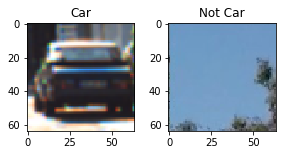

In [2]:
img_car = mpimg.imread('datasets/vehicles/KITTI_extracted/1.png')
img_notcar = mpimg.imread('datasets/non-vehicles/Extras/extra1.png')
fig = plt.figure()
plt.subplot(131)
plt.imshow(img_car)
plt.title('Car')
plt.subplot(132)
plt.imshow(img_notcar)
plt.title('Not Car')
fig.tight_layout()

## Define a classifier for car detection

In [3]:
class CarSVC():
    
    def __init__(self):
        # Create a linear SVM as classifier
        self.svc = None
        self.X_scaler = StandardScaler()
        
    ### Prepare train and test data
    def _get_cars(self):
        train = glob.glob('datasets/vehicles/KITTI*/*.png')
        test = glob.glob('datasets/vehicles/GTI*/*.png')
        return train, test
    
    def _get_notcars(self):
        train = glob.glob('datasets/non-vehicles/Extras/*.png')
        test = glob.glob('datasets/non-vehicles/GTI/*.png')
        return train, test

    def train(self):
        cars_train, cars_test = self._get_cars()
        notcars_train, notcars_test = self._get_notcars()
        print( 'Number of cars: {}, Number of not-cars: {}'.format( 
            len(cars_train)+len(cars_test), len(notcars_train)+len(notcars_test) ) )
        
        # Extract features and labels
        print('# Extracting...')
        X_train, y_train = extract_features(cars_train, notcars_train)
        X_test, y_test = extract_features(cars_test, notcars_test)
        print('# Extract done!')
        
        # Split up a few part of X_test into X_train
        rand_state = np.random.randint(0, 100)
        X_train1, X_test, y_train1, y_test = train_test_split(
                    X_test, y_test, test_size=0.8, random_state=rand_state)
        X_train = np.concatenate( (X_train, X_train1) )
        y_train = np.concatenate( (y_train, y_train1) )
        print('Number of train:', len(X_train))
        print('Number of test:', len(X_test))
        
        ### Normalize                       
        # Fit a per-column scaler
        self.X_scaler.fit( np.concatenate( (X_train, X_test) ) )
        # Apply the scaler to X
        X_train = self.X_scaler.transform( X_train )
        X_test = self.X_scaler.transform( X_test )

        # Train
        print('# Training...')
        t = time.time()
        #params = {'kernel': ['linear'], 'C': [1, 10]} 
        #self.svc = GridSearchCV(SVC(), params).fit( X_train, y_train )
        self.svc = LinearSVC().fit( X_train, y_train )
        t2 = time.time()
        print( round( t2 - t, 2 ), 'Seconds to train SVC...' )
        #print( 'SVC best params:', self.svc.best_params_ )
        
        # Test
        print('Test Accuracy of SVC = ', round(self.svc.score(X_test, y_test), 4))

## Train the classifier

In [4]:
clf = CarSVC()
clf.train()

Number of cars: 8792, Number of not-cars: 8968
# Extracting...


C:\Users\Leon\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


# Extract done!
Number of train: 12379
Number of test: 5381
# Training...
5.21 Seconds to train SVC...
Test Accuracy of SVC =  0.9758


## Define a CarFinder class to find cars

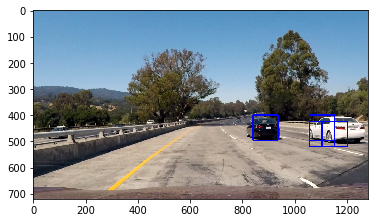

In [64]:
from scipy.ndimage.measurements import label

class CarFinder():
    
    def __init__(self, clf):
        self.clf = clf
        self.bboxs = []

    # Define a single function that can extract features using hog sub-sampling and make predictions
    def find_cars(self, img, ystart=400, ystop=656, scale=1.5, \
                  orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32):
        
        svc, X_scaler = self.clf.svc, self.clf.X_scaler
        
        img = img.astype(np.float32) / 255 # Convert to (0, 1)
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, \
                            (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - 1 
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - 1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1 
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        bbox = []
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * pix_per_cell
                ytop = ypos * pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop : ytop + window, xleft : xleft + window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(
                    np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft * scale)
                    ytop_draw = np.int(ytop * scale)
                    win_draw = np.int(window * scale)
                    bbox.append( ( (xbox_left, ytop_draw + ystart),
                                  (xbox_left + win_draw, ytop_draw + win_draw + ystart) ) )
                    #cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                    #              (xbox_left + win_draw, ytop_draw + win_draw + ystart),
                    #              (0,0,255), 6)

        return bbox

    # Draw labels onto image
    def draw_labels(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img
    
    # Apply thresh on heatmap for single frame
    def heat_thresh(self, img, thresh=4):
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        bboxs = self.bboxs[-6:]
        for bbox1, bbox2 in bboxs:
            for box in bbox1: # More confident
                heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += thresh + 1
            for box in bbox2: # Less confident
                heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        heat[ heat <= thresh ] = 0
        return heat

    # Draw boxes for single frame
    def draw_bbox(self, img, bbox1=None, bbox2=None):
        draw_img = np.copy(img)
        if bbox1 is not None:
            for box in bbox1:
                cv2.rectangle(draw_img, box[0], box[1], (255,0,0), 6)
        if bbox2 is not None:
            for box in bbox2:
                cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 4)
        return draw_img

    # Draw final detections onto image
    def draw_cars(self, img):
        bbox1 = finder.find_cars(img, scale=2.0) # More confident
        bbox2 = finder.find_cars(img, scale=1.5) # Less confident
        self.bboxs.append( [bbox1, bbox2] )
    
        heat = self.heat_thresh(img, thresh=4)
        labels = label(heat)
        draw_img = self.draw_labels(np.copy(img), labels)
        return draw_img

finder = CarFinder(clf)

img = mpimg.imread('test_images/test1.jpg')
bbox = finder.find_cars(img, scale=1.5)
test = finder.draw_bbox(img, bbox2=bbox)

plt.imshow(test)

## Save the trained classifier

In [6]:
import pickle

with open('clf.pickle', 'wb') as f:
    pickle.dump(clf, f)

## Extract all the frames from Project Vedio

In [7]:
from moviepy.editor import VideoFileClip

clip = VideoFileClip('project_video.mp4')

frames = [frame for frame in clip.iter_frames()]


## Load classifier and make detections on any given frame

In [41]:
with open('clf.pickle', 'rb') as f:
    clf2 = pickle.load(f)

In [59]:
def heat_thresh(img, bboxs, thresh=4):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    for bbox1, bbox2 in bboxs:
        for box in bbox1:
            heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += thresh + 1
        for box in bbox2:
            heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    heat[ heat <= thresh ] = 0
    return heat

def draw_bbox(img, bbox1, bbox2):
    draw_img = np.copy(img)
    for box in bbox1:
        cv2.rectangle(draw_img, box[0], box[1], (255,0,0), 6)
    for box in bbox2:
        cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 4)
    return draw_img

def draw_cars(finder, img, bboxs):
    heat = heat_thresh(img, bboxs, thresh=4)
    labels = label(heat)
    draw_img = finder.draw_labels(np.copy(img), labels)
    return draw_img

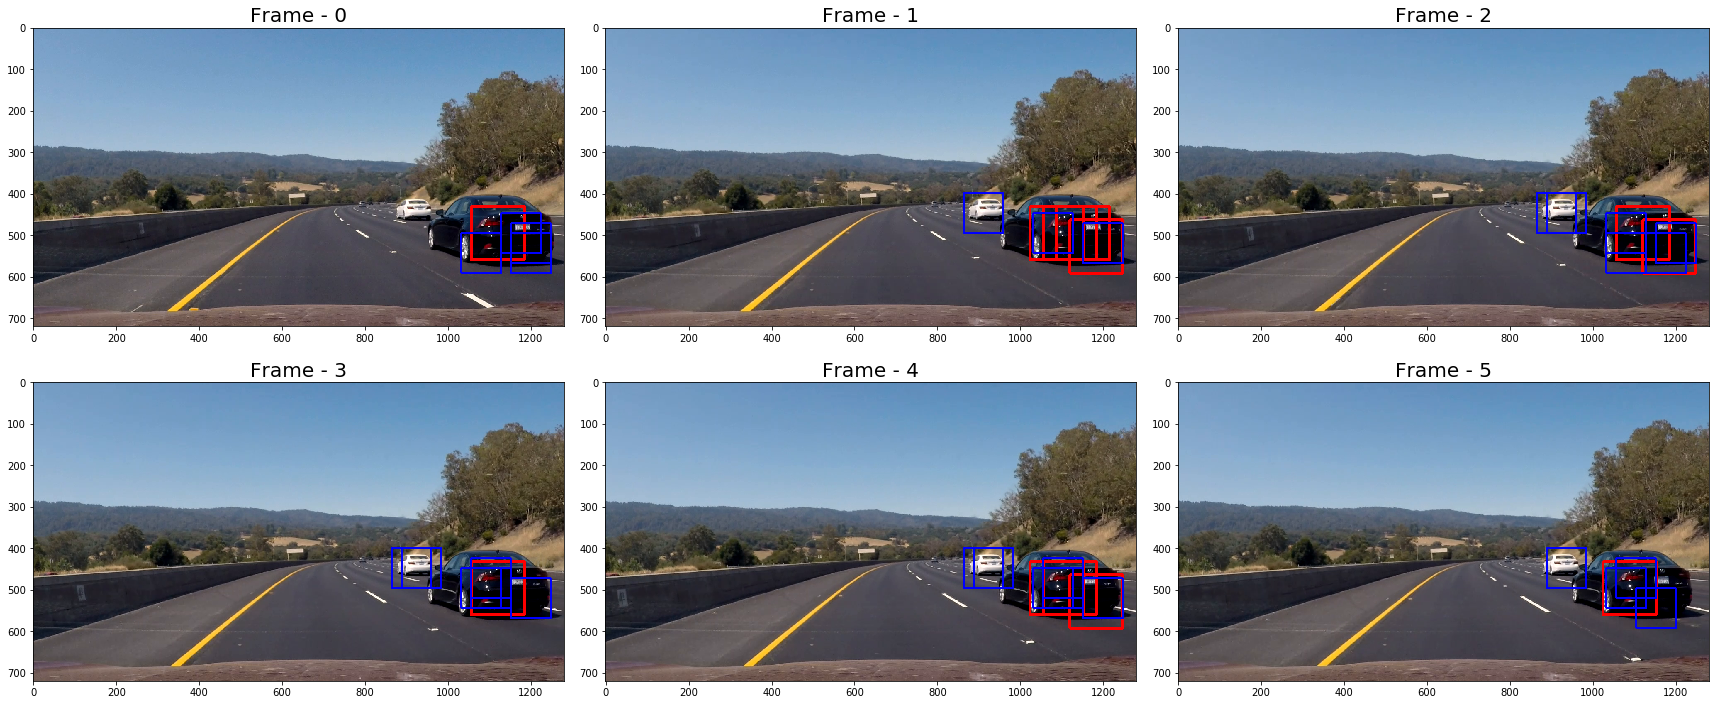

In [74]:
finder = CarFinder(clf2)

# The given frame
start = int(clip.fps * 30)
# Hold the images for next 6 frames
imgs = [frames[i + start] for i in range(6)]
bboxs = []

f, axs = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()

for i in range( 0, 6 ):
    img = imgs[i]

    bbox1 = finder.find_cars(img, scale=2.0) # More confident, with red color
    bbox2 = finder.find_cars(img, scale=1.5) # Less confident, with blue color

    #heat = finder.heat_thresh(img, bbox, thresh=0)
    cars = draw_bbox(img, bbox1, bbox2)
    bboxs.append( [bbox1, bbox2] )
    ax = axs[i // 3][i % 3]
    ax.imshow(cars)
    ax.set_title('Frame - {}'.format(i), fontsize=20)

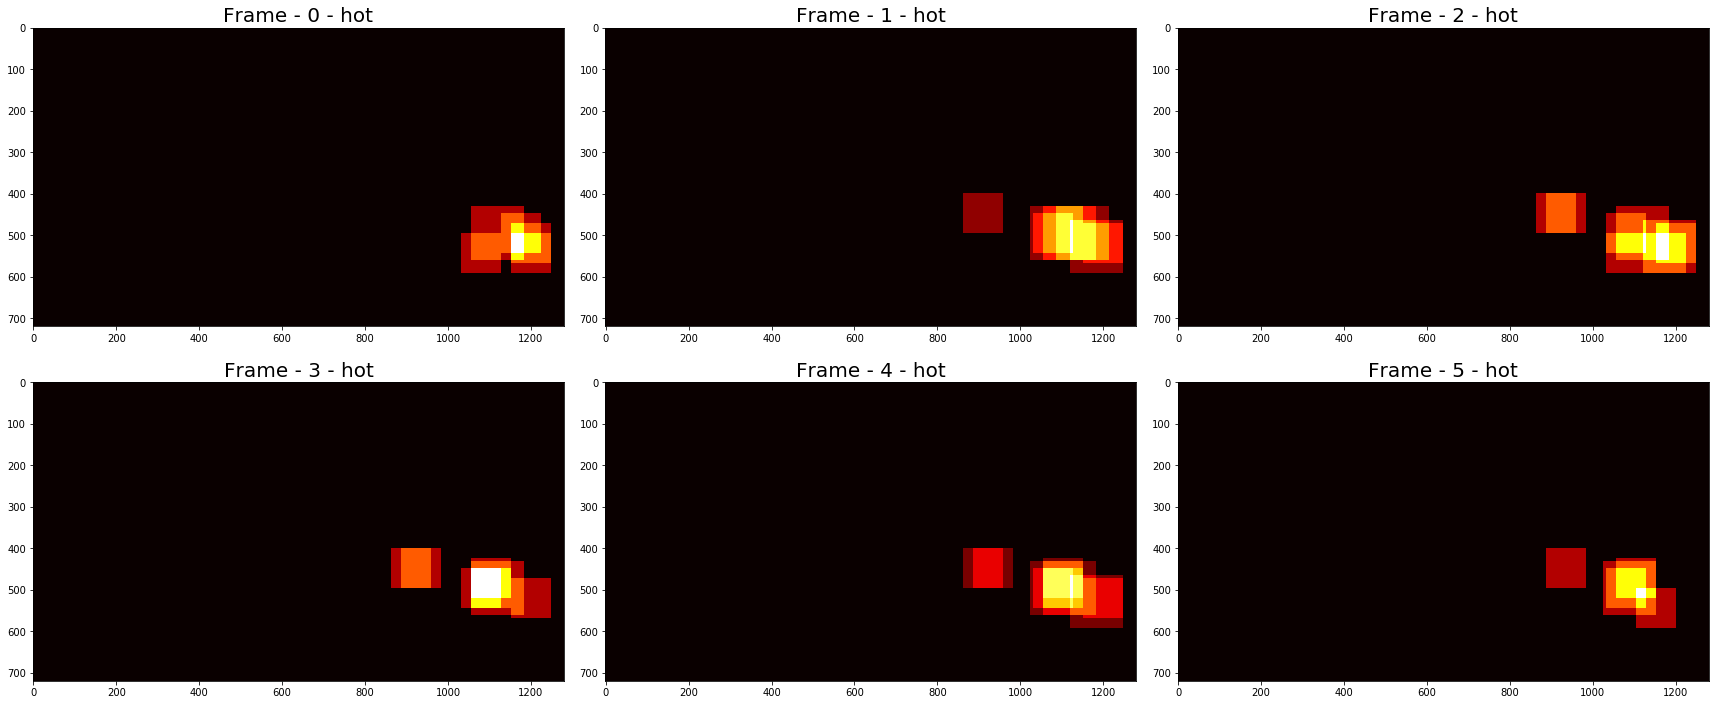

In [77]:
f, axs = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()

for i in range( 0, 6 ):
    img = imgs[i]
    heat = heat_thresh(img, [ bboxs[i] ], thresh=0)

    ax = axs[i // 3][i % 3]
    ax.imshow(heat, cmap='hot')
    ax.set_title('Frame - {} - hot'.format(i), fontsize=20)

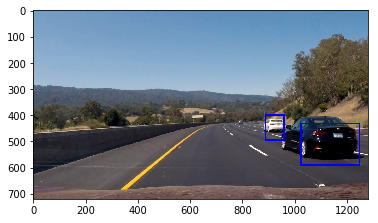

In [75]:
img = imgs[5]
draw_img = draw_cars(finder, img, bboxs)

plt.imshow( draw_img )

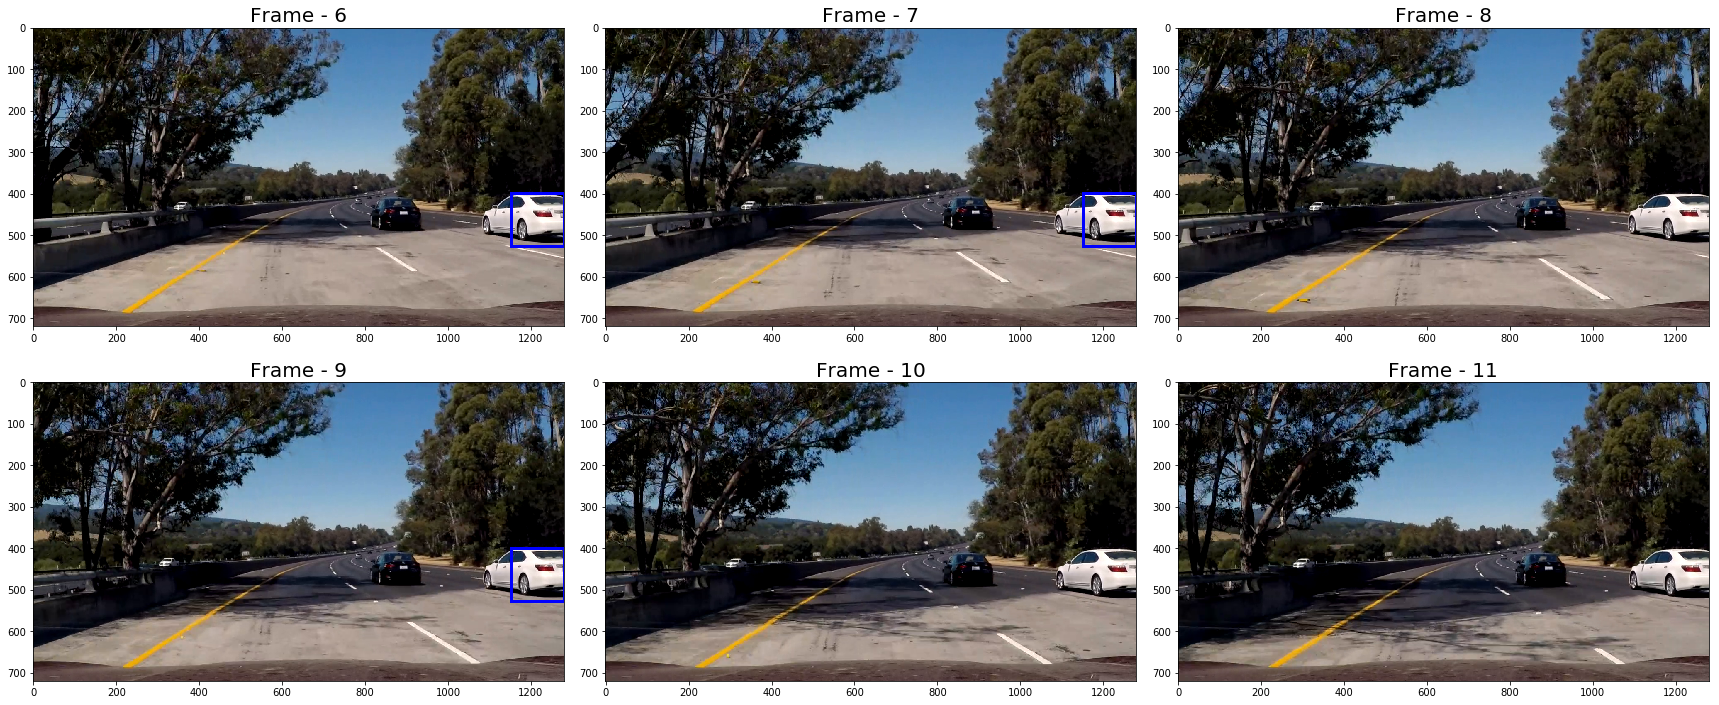

In [36]:
finder = CarFinder(clf2)

# The given frame
start = int(clip.fps * 41)
# Hold the images for next 12 frames
imgs = [frames[i + start] for i in range(12)]

f, axs = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()

for i in range( 0, 12 ):
    img = imgs[i]
    bbox = finder.find_cars(img, scale=2.0)
    #bbox = bbox1 + bbox2
    #heat = finder.heat_thresh(img, bbox, thresh=0)
    cars = finder.draw_bbox(img, bbox)
    #bboxs.append(bbox)
    if i >= 6:
        ax = axs[(i-6) // 3][(i-6) % 3]
        ax.imshow(cars)
        ax.set_title('Frame - {}'.format(i), fontsize=20)

## Draw labeled cars on any given frame

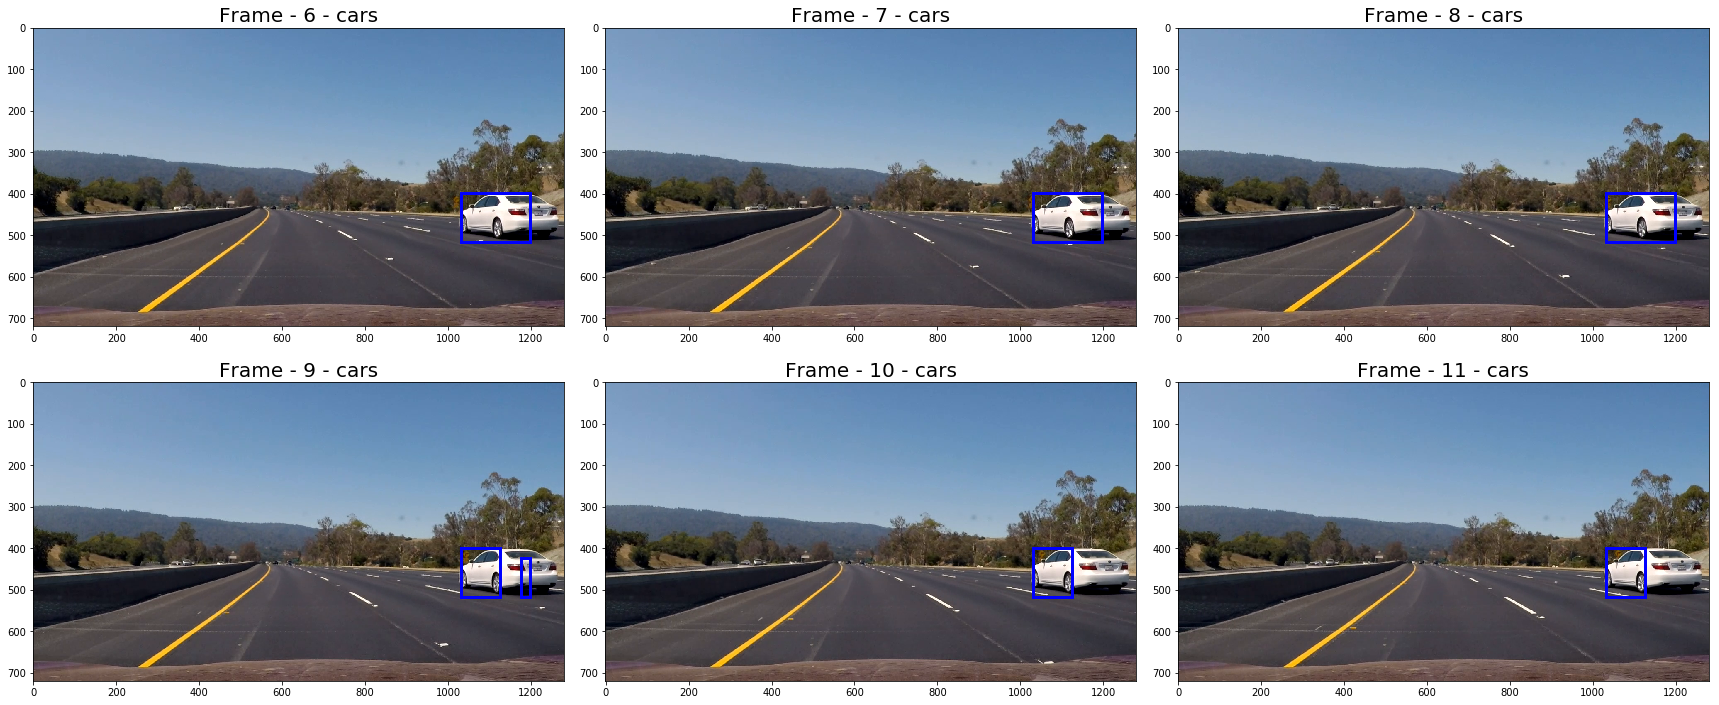

In [13]:
finder = CarFinder(clf2)
start = int(clip.fps*10)
imgs = [frames[i + start] for i in range(12)]

f, axs = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()

for i in range( 0, 12 ):
    img = imgs[i]
    img_cars = finder.draw_cars_cons(img, thresh=2)

    if i >= 6:
        ax = axs[(i-6) // 3][(i-6) % 3]
        ax.imshow(img_cars)
        ax.set_title('Frame - {} - cars'.format(i), fontsize=20)

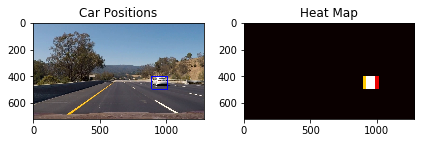

In [15]:
img = imgs[-1]
heat = finder.heat_thresh_cons(img)
draw_img = finder.draw_cars_cons(img)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heat, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [67]:
from moviepy.editor import VideoFileClip

with open('clf.pickle', 'rb') as f:
    clf_p = pickle.load(f)
    
finder = CarFinder(clf_p)

video_output = 'project_output.mp4'
clip = VideoFileClip('project_video.mp4')

output_clip = clip.fl_image( finder.draw_cars )
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████████████████████████████████████████████████████▉| 1260/1261 [10:46<00:00,  1.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 10min 47s
